# Import Librerie

In [126]:
from keras import *
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Activation, LeakyReLU, Dropout
from keras.optimizers import SGD
from tensorflow.keras.activations import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os 
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Import File

In [73]:
# Commands if you are using google colab

from google.colab import files
files.upload()

{}

## Utility

In [127]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = MinMaxScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

## Caricamento Dati & Analisi iniziale

In [128]:
x_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

#Rimozione Colonne ID
x_train.drop(['Unnamed: 0'], axis=1, inplace=True)
y_train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
x_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.71239,-73.95271,4,2,0.19,1,0,1,0
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0
2,40.62707,-74.02817,3,1,0.04,1,87,0,0
3,40.77910,-73.98565,1,4,0.08,1,0,0,1
4,40.75777,-73.93509,1,0,0.00,1,358,1,0


In [7]:
y_train.head()

,price
0,65
1,57
2,225
3,175
4,125


In [8]:
x_train.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000
mean,393.742123,-767.324528,7.109904,23.391778,1.095455,7.101080,112.995839,0.456085,0.520127
std,3773.366411,7123.758128,20.234836,44.608022,1.610452,32.746915,131.641035,0.498075,0.499602
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.690427,-73.983503,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723645,-73.956025,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,1.000000
75%,40.763910,-73.937005,5.000000,24.000000,1.590000,2.000000,227.000000,1.000000,1.000000
max,40894.000000,-73.712990,1000.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000


In [9]:
y_train.describe()

,price
count,33884.000000
mean,153.605389
std,249.102710
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


In [10]:
x_train.dtypes

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
dtype: object

In [11]:
x_train.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
dtype: int64

##Correlazione tra feature e target
Inizialmente è stato pensato di eseguire feature selection, in modo da rimuovere tutte quelle feature con basso grado di correlazione con la variabile target minore (es Minimum_Nights). Però questo approccio è stato abbandonato in quanto non ha portato ad un significativo incremento delle performance del modello. Quindi il modello è stato allenato utilizzando tutte le feature del dataset.

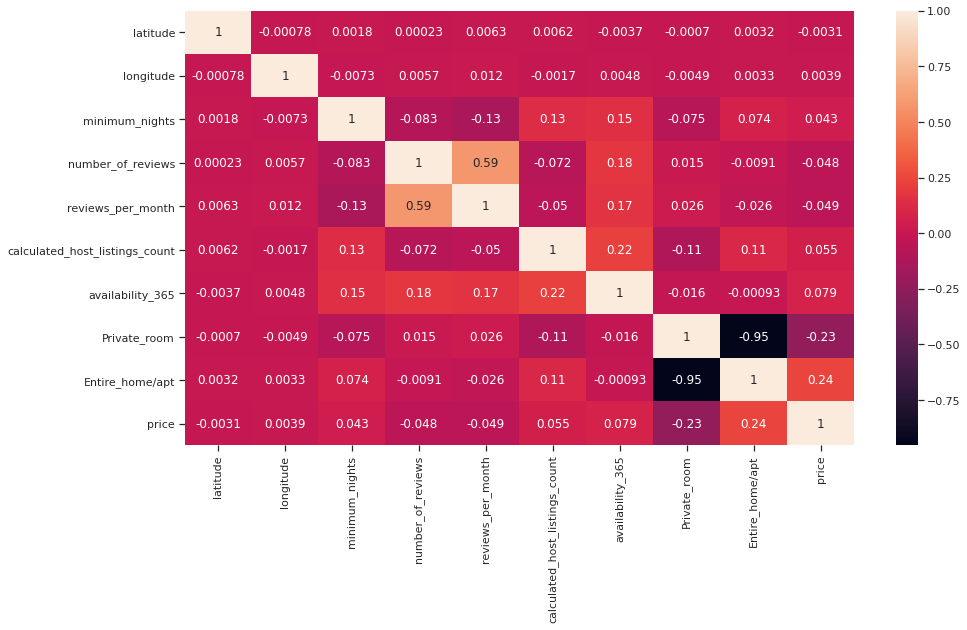

In [13]:
dataset = x_train
dataset = dataset.assign(price = y_train) 
corr = dataset.corr(method='pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

##Preprocessing

E' stata applicata una normalizzazione ai valori di train (sia le feature sia la variabile target) in modo da riportare i valori in un range compreso tra 0 e 1

In [129]:
x_train, scaler = preprocess_data(x_train)
y_train, scaler1 = preprocess_data(y_train)

In [130]:
print(x_train[0])
print('Train dimensions:', x_train.shape)

[5.20396047e-06 9.99996764e-01 3.00300300e-03 3.17965024e-03
 3.24786325e-03 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00]
Train dimensions: (33884, 9)


In [131]:
print('Minimum value of the target variable:', int(y_train.min()))
print('Maximum value of the target variable:', int(y_train.max()))
print('Target dims', y_train.shape)

Minimum value of the target variable: 0
Maximum value of the target variable: 1
Target dims (33884, 1)


## GridSearch  

Per trovare i parametri migliori per allenare la rete è stata applicata una tecnica di GridSearch. Questa consiste nel provare diversi tipi di parametri iniziali e al termine dell'esecuzione vengono restituiti i parametri migliori che hanno ottimizzato al meglio la metrica richiesta. 

La funzione FindLayerNodesLinear restituisce il numero di neuroni per ogni hidden layer in modo decrescente, partendo dal numero di input e arrivando a quello di output.

La funzione createmodel serve a creare la rete vera e propria, è composta da n layers in base al parametro in input e ogni livello conterrà un numero differente di neuroni in base al layer. 

Per allenare questo modello è stata fissata sia la funzione di attivazione (relu hidden layer e sigmoid output layer), sia la loss function (mse) e anche la metrica (rmse). In questo modo è stato possibile concentrarsi maggiormente sulla struttura della rete.

I parametri passati in fase di training sono diversi:
- n_layers=[3,4,5] => permette di capire quanti livelli dovrebbe avere la rete. L'analisi è stata fatta solo tra 3 e 5 livelli, perché aumentando il numero la fase di training diventava troppo onerosa. 

- first_layer_nodes = [256,128,64] => permette di capire quanti neuroni dovrebbe avere il primo layer.

- last_layer_nodes = [64,32,16] => permette di capire quanti neuroni dovrebbe avere l'ultimo layer.

- batch_size = [64,128,256] => permette di capire quale è la batch size migliore.

- epochs = [10,20] => permette di capire quale è il numero di epochs migliore.
E' stato scelto di avere numero basso di epochs perché altrimenti il training diventava troppo oneroso. 

Dopo l'esecuzione del comando grid.fit(X_train, y_train) sono stati trovati questi parametri ottimi:
{'batch_size': 64, 'epochs': 20, 'first_layer_nodes': 128, 'last_layer_nodes': 16, 'n_layers': 5}

Da questi parametri si è deciso di partire per allenare la rete vera e propria, formata da 5 livelli con 128 units al primo e all'ultimo solo 16.
Utilizzando la funzione FindLayerNodesLinear(5, 128, 16) si possono vedere i neurons per ogni livello. 

[128, 100, 72, 44, 16]

Reference: https://datagraphi.com/blog/post/2019/12/17/how-to-find-the-optimum-number-of-hidden-layers-and-nodes-in-a-neural-network-model

In [20]:
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []

    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment

    return layers

def rmse(y_true, y_pred):
  return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def createmodel(n_layers, first_layer_nodes, last_layer_nodes):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation='relu'))
        else:
            model.add(Dense(n_nodes[i-1], activation='relu'))

    model.add(Dense(y_train.shape[1], activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics = [rmse])

    return model

#model = KerasRegressor(build_fn=createmodel, verbose = False)

#param_grid = dict(n_layers=[3,4,5], first_layer_nodes = [256,128,64], last_layer_nodes = [64,32,16], batch_size = [64,128,256], epochs = [10,20])

#grid = GridSearchCV(estimator = model, param_grid = param_grid)

#grid.fit(X_train, y_train)

In [ ]:
#print("Best using %s" % (grid.best_params_))
#Best using {'batch_size': 64, 'epochs': 20, 'first_layer_nodes': 128, 'last_layer_nodes': 16, 'n_layers': 5}

In [21]:
FindLayerNodesLinear(5, 128, 16)
#[128, 100, 72, 44, 16]

[128, 100, 72, 44, 16]

## Train & Test

E' stata costruita la rete utilizzando le metriche trovate prima, sono stati introdotti due livelli di Dropout in modo da evitare che la rete overfitti troppo. Per evitare questo è stato anche introdotto il EarlyStopping con patience = 10, in modo che dopo 10 epochs senza nessun miglioramento rispetto alla loss function il training viene stoppato.

Sono state utilizzate tutte le funzioni di attivazione in fase di allenamento del modello. 

Come loss function è stato provato sia mean_squared_logarithmic_error che mse e non sono state trovate particolari differenze nei risultati. Mentre per quanto riguarda l'optimizer è stato provato un approccio SGD, ma le performance sono decisamente peggiorate, quindi è stato utilizzato un ottimizzatore base come adam. 

In [133]:
X_train, X_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [55]:
def NeuralNetwork(X, activation, n_outputs):
    inputs = Input(shape = (X.shape[1]))
    x = layers.Dense(128, activation = activation) (inputs)
    x = layers.Dense(100, activation = activation) (x)
    x = layers.Dense(72, activation = activation) (x)
    x = Dropout(0.3) (x)
    x = layers.Dense(44, activation = activation) (x)
    x = layers.Dense(16, activation = activation) (x)
    x = Dropout(0.3) (x)
    output = layers.Dense(n_outputs, activation = 'sigmoid') (x)
    model = Model(inputs, output)
    model.compile(loss = 'mse', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError()]) 
    return model

In [56]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'gelu': Activation(gelu)})
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})
get_custom_objects().update({'swish': Activation(swish)})

act_func = ['relu', 'elu', 'leaky-relu', 'selu', 'gelu', 'softmax', 'swish']

In [57]:
result = []
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
    dims = y_train.shape[1]
    model = NeuralNetwork(activation=activation, X = X_train, n_outputs=dims)
    
    history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=0,
          validation_data=(X_validation, y_validation),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10)]) # EarlyStopping patient 10 epoch
    
    result.append(history)
    
    K.clear_session()
    del model


Training with -->relu<-- activation function


Training with -->elu<-- activation function


Training with -->leaky-relu<-- activation function


Training with -->selu<-- activation function


Training with -->gelu<-- activation function


Training with -->softmax<-- activation function


Training with -->swish<-- activation function



<Figure size 720x504 with 0 Axes>

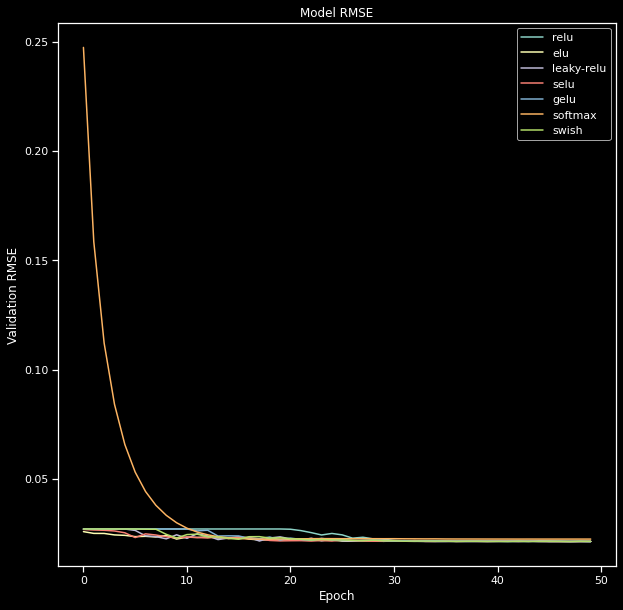

In [58]:
rmse_finale = []

def risultati(activation_function, rmse):
    for i in range(len(activation_function)):
        print('RMSE of the activation function {} is {}'.format(activation_function[i], round(rmse[i], 5)))
        
def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    
    # Plot of the validation root mean squared error
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_root_mean_squared_error'])
        rmse_finale.append(act_func.history['val_root_mean_squared_error'][-1])
    
    plt.title('Model RMSE')
    plt.ylabel('Validation RMSE')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(result, act_func)

In [86]:
risultati(act_func,rmse_finale)
#RMSE of the activation function relu is 0.02136
#RMSE of the activation function elu is 0.02139
#RMSE of the activation function leaky-relu is 0.02133
#RMSE of the activation function selu is 0.02143
#RMSE of the activation function gelu is 0.02136
#RMSE of the activation function softmax is 0.02246
#RMSE of the activation function swish is 0.0214

RMSE of the activation function relu is 0.02136
RMSE of the activation function elu is 0.02139
RMSE of the activation function leaky-relu is 0.02133
RMSE of the activation function selu is 0.02143
RMSE of the activation function gelu is 0.02136
RMSE of the activation function softmax is 0.02246
RMSE of the activation function swish is 0.0214


## Predict

E' possibile vedere come la funzione di attivazione con valore minore di RMSE è la Leaky-RELU con un valore di 0.02133. Pertanto è stata selezionata per allenare il modello

In [134]:
activation = 'leaky-relu'

model = NeuralNetwork(activation=activation, X = X_train, n_outputs=dims)
model.summary()
model.fit(X_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=0,
          validation_data=(X_validation, y_validation),
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10)])


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_25 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_26 (Dense)             (None, 72)                7272      
_________________________________________________________________
dropout_8 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 44)                3212      
_________________________________________________________________
dense_28 (Dense)             (None, 16)               

In [135]:
x_test = pd.read_csv("X_test.csv")
x_test.drop(['Unnamed: 0'], axis=1, inplace=True)
x_test, scaler = preprocess_data(x_test)

In [136]:
y_test = model.predict(x_test)

In [137]:
y_test_final = scaler1.inverse_transform(y_test)
print(y_test_final)

[[192.50723 ]
 [ 79.07849 ]
 [ 71.406456]
 ...
 [187.20258 ]
 [202.76959 ]
 [ 89.35898 ]]


In [139]:
with open("Fabio_Beltramelli_816912_score1.txt", 'w') as f:
    for item in y_test_final:
        f.write(str(item)+",\n")